In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn import model_selection

validate_df = pd.read_csv('train.csv').sample(20000,random_state=1234)

IDENTITY_COLUMNS = [
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness']
TOXICITY_COLUMN = 'target'
TEXT_COLUMN = 'comment_text'

# Convert target

def convert_to_bool(df, col_name):
    df[col_name] = np.where(df[col_name] >= 0.5, True, False)
    
def convert_dataframe_to_bool(df):
    bool_df = df.copy()
    for col in ['target'] + IDENTITY_COLUMNS:
        convert_to_bool(bool_df, col)
    return bool_df

validate_df = convert_dataframe_to_bool(validate_df)
#print(validate_df.head(n=10))

# Define bias metrics

SUBGROUP_AUC = 'subgroup_auc'
BPSN_AUC = 'bpsn_auc'  # stands for background positive, subgroup negative
BNSP_AUC = 'bnsp_auc'  # stands for background negative, subgroup positive

def compute_auc(y_true, y_pred):
    try:
        return metrics.roc_auc_score(y_true, y_pred)
    except ValueError:
        return np.nan

def compute_subgroup_auc(df, subgroup, label, model_name):
    subgroup_examples = df[df[subgroup]]
    return compute_auc(subgroup_examples[label], subgroup_examples[model_name])

def compute_bpsn_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup negative examples and the background positive examples."""
    subgroup_negative_examples = df[df[subgroup] & ~df[label]]
    non_subgroup_positive_examples = df[~df[subgroup] & df[label]]
    examples = subgroup_negative_examples.append(non_subgroup_positive_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bnsp_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup positive examples and the background negative examples."""
    subgroup_positive_examples = df[df[subgroup] & df[label]]
    non_subgroup_negative_examples = df[~df[subgroup] & ~df[label]]
    examples = subgroup_positive_examples.append(non_subgroup_negative_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bias_metrics_for_model(dataset,
                                   subgroups,
                                   model,
                                   label_col,
                                   include_asegs=False):
    """Computes per-subgroup metrics for all subgroups and one model."""
    records = []
    for subgroup in subgroups:
        record = {
            'subgroup': subgroup,
            'subgroup_size': len(dataset[dataset[subgroup]])
        }
        record[SUBGROUP_AUC] = compute_subgroup_auc(dataset, subgroup, label_col, model)
        record[BPSN_AUC] = compute_bpsn_auc(dataset, subgroup, label_col, model)
        record[BNSP_AUC] = compute_bnsp_auc(dataset, subgroup, label_col, model)
        records.append(record)
    return pd.DataFrame(records).sort_values('subgroup_auc', ascending=True)

# Calculate the final score

def calculate_overall_auc(df, model_name):
    true_labels = df[TOXICITY_COLUMN]
    predicted_labels = df[model_name]
    return metrics.roc_auc_score(true_labels, predicted_labels)

def power_mean(series, p):
    total = sum(np.power(series, p))
    return np.power(total / len(series), 1 / p)

def get_final_metric(bias_df, overall_auc, POWER=-5, OVERALL_MODEL_WEIGHT=0.25):
    bias_score = np.average([
        power_mean(bias_df[SUBGROUP_AUC], POWER),
        power_mean(bias_df[BPSN_AUC], POWER),
        power_mean(bias_df[BNSP_AUC], POWER)
    ])
    return (OVERALL_MODEL_WEIGHT * overall_auc) + ((1 - OVERALL_MODEL_WEIGHT) * bias_score)
    

In [2]:
# Scores of individual models
validate_df['LSTM'] = pd.read_pickle('val_pred_lstm')
validate_df['BERT'] = pd.read_pickle('val_pred_bert')
for MODEL_NAME in ("LSTM", "BERT"):
    bias_metrics_df = compute_bias_metrics_for_model(validate_df, IDENTITY_COLUMNS, MODEL_NAME, TOXICITY_COLUMN)
    score = get_final_metric(bias_metrics_df, calculate_overall_auc(validate_df, MODEL_NAME))
    print("{}: {:.4f}".format(MODEL_NAME, score)) 

LSTM: 0.9396
BERT: 0.9370


In [3]:
# Grid search of optimized combined model
weights = []
scores = []
for i in range(0, 100, 1):
    weight = float(i)/100
    MODEL_NAME = str(weight)
    validate_df[MODEL_NAME] = validate_df['LSTM']*weight + validate_df['BERT']*(1-weight)
    bias_metrics_df = compute_bias_metrics_for_model(validate_df, IDENTITY_COLUMNS, MODEL_NAME, TOXICITY_COLUMN)
    score = get_final_metric(bias_metrics_df, calculate_overall_auc(validate_df, MODEL_NAME))
    weights.append(weight)
    scores.append(score)
    
highest_score = max(scores)
index = scores.index(highest_score)
print("COMB: {:.4f} at LSTM's weight {}".format(highest_score, weights[index]))


COMB: 0.9439 at LSTM's weight 0.69


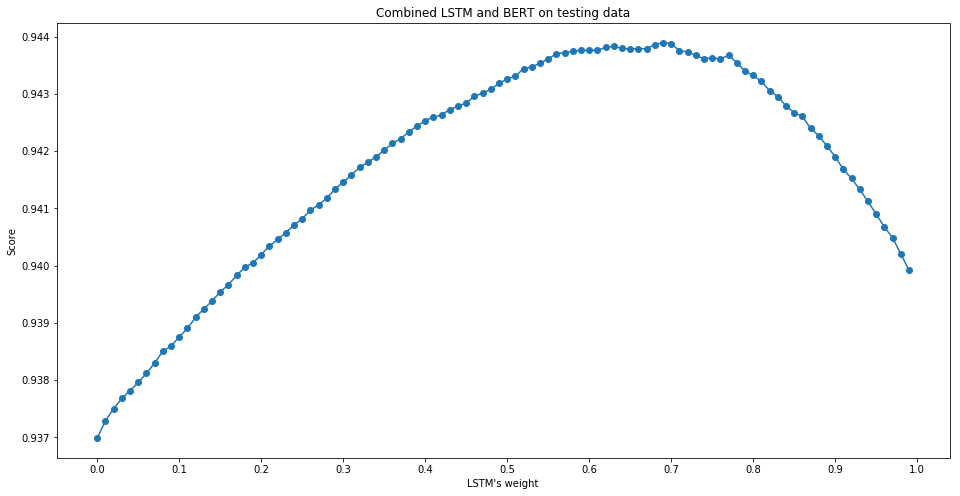

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(16, 8))
plt.plot(weights, scores, '-o')
plt.xlabel("LSTM's weight")
plt.ylabel("Score")
plt.title("Combined LSTM and BERT on testing data")
plt.xticks(np.arange(0, 1.1, step=0.1))
plt.show()